In [1]:
import torch
import numpy as np
#import openmm
import pickle
import mdtraj
from openmmtools import integrators
from simtk import unit
from simtk import openmm
import pandas as pd

In [2]:
device = "cuda:3" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

ctx = torch.zeros([], device=device, dtype=dtype)

In [4]:
# from simtk import openmm
# with open('ala2_xml_system.txt') as f:
#     xml = f.read()
# system = openmm.XmlSerializer.deserialize(xml)

# from bgflow.distribution.energy.openmm import OpenMMBridge, OpenMMEnergy
# from openmmtools import integrators
# from simtk import unit
# temperature = 300.0 * unit.kelvin
# collision_rate = 1.0 / unit.picosecond
# timestep = 4.0 * unit.femtosecond
# integrator = integrators.LangevinIntegrator(temperature=temperature,collision_rate=collision_rate,timestep=timestep)

# energy_bridge = OpenMMBridge(system, integrator, n_workers=1)
# target_energy_xml_300 = OpenMMEnergy(66, energy_bridge)

In [5]:
# import mdtraj

# obc_1000K_MD = mdtraj.load('1000K.dcd', top = 'ala2_fromURL.pdb',stride=4.6796)

In [6]:
# def get_energies(trajectory, target_energy):
#     coordinates = trajectory.xyz
#     data = torch.tensor(coordinates.reshape(-1,66)).to(ctx)
#     return target_energy.energy(data).cpu().detach().numpy()

In [3]:
def find_stride(fname, top_file, fpath_stub):

    if 'coupled' in fname:
        traj = mdtraj.load(f'Coupled_scheme/Trajectories/{fname}.dcd',top=top_file)
    else:
        traj = mdtraj.load(f'{fpath_stub}/Trajectories/{fname}.dcd',top=top_file)

    print(traj.n_frames/10000)
    return len(traj), traj.n_frames/10000

In [14]:
def get_pot_energies(fname, molecule):
    if molecule == 'pro':
        fpath_stub = 'proline'
        top_file = f'{fpath_stub}/cis_pro.pdb'
        system_file = f'{fpath_stub}/noconstraints_xmlsystem.txt'
        n_atoms = 26
    elif molecule == 'ala2':
        fpath_stub = 'Alanine_dipeptide'
        top_file = 'Alanine_dipeptide/ala2_fromURL.pdb'
        system_file = 'Alanine_dipeptide/ala2_noconstraints_system.txt'
        n_atoms = 22
    else:
        print('molecule not recognised')
    

    with open(system_file) as f:
        xml = f.read()
    system = openmm.XmlSerializer.deserialize(xml)

    from bgflow.distribution.energy.openmm import OpenMMBridge, OpenMMEnergy
    from openmmtools import integrators
    from simtk import unit
    import pickle

    try:
        pickleFile = open(f'{fpath_stub}/parameters/parameters{fname}.pkl','rb')
        parametersdict = pickle.load(pickleFile)
        temperature = parametersdict['Temperature']
        collision_rate = parametersdict['Collision rate']
        timestep = parametersdict['Timestep']
    except:
        print(f'{fname} no parameters found')
        if 'coupled' in fname or '1000' in fname:
            print(f'{fname}using 1000K')
            temperature = 1000.0 * unit.kelvin
            collision_rate = 1.0 / unit.picosecond
            timestep = 2.0 * unit.femtosecond
        else:
            print(f'{fname} using 300K')
            temperature = 300.0 * unit.kelvin
            collision_rate = 1.0 / unit.picosecond
            timestep = 2.0 * unit.femtosecond

    
    
    integrator = integrators.LangevinIntegrator(temperature=temperature,collision_rate=collision_rate,timestep=timestep)

    energy_bridge = OpenMMBridge(system, integrator, n_workers=1)
    target_energy = OpenMMEnergy(n_atoms*3, energy_bridge)
    data_len, stride = find_stride(fname, top_file, fpath_stub)

    if 'coupled' in fname:
        trajectory = mdtraj.load(f'Coupled_scheme/Trajectories/{fname}.dcd',top=top_file,stride=stride)
    else:
        trajectory = mdtraj.load(f'{fpath_stub}/Trajectories/{fname}.dcd',top=top_file,stride=stride)
    coordinates = trajectory.xyz[0:10000]
    data = torch.tensor(coordinates.reshape(-1,n_atoms*3)).to(ctx)
    energies = target_energy.energy(data).cpu().detach().numpy()
    if np.percentile(energies, 99) > 100:
        data_max = np.percentile(energies,98)
    else:
        data_max = max(energies)
    data_min = min(energies)

    return energies, data_len, data_max, data_min

In [5]:
def get_energy_fromtxt(fname, column, molecule):
    if molecule == 'pro':
        fpath_stub = 'proline'
    elif molecule == 'ala2':
        fpath_stub = 'Alanine_dipeptide'

    if 'coupled' in fname:
        data = pd.read_csv(f'Coupled_scheme/Trajectories/{fname}.txt')
    else:
        data = pd.read_csv(f'{fpath_stub}/Trajectories/{fname}.txt')
    #data.name = f'{fname}'
    if len(data) > 10000:
        step = len(data)//10000
    else:
        step = 1
    return data[column].to_numpy()[::step], len(data), max(data[column].to_numpy()[::step]), min(data[column].to_numpy()[::step])

In [7]:
def average_energy(trajectory, target_energy, molecule):
    coordinates = trajectory.xyz
    data = torch.tensor(coordinates.reshape(-1,66)).to(ctx)
    energies = target_energy.energy(data).cpu().detach().numpy()
    return np.average(energies)

In [10]:
def plot_energy(ax,
        *fnames, molecule='ala2', total_energy=False, kinetic_energy=False, potential_energy=False):
    
    energies = {}
    lengths = {}
    maxes = {}
    mins = {}
    
    if total_energy == True:
        print('total energy from txt')
        for fname in fnames:
              energies[fname], lengths[fname], maxes[fname], mins[fname] = get_energy_fromtxt(fname, 'Total Energy (kJ/mole)', molecule)
        label = 'Total'
    elif kinetic_energy==True:
        for fname in fnames:
            energies[fname], lengths[fname], maxes[fname], mins[fname] = get_energy_fromtxt(fname, 'Kinetic Energy (kJ/mole)', molecule)
        label = 'Kinetic'
    elif potential_energy==True:
        for fname in fnames:
            energies[fname], lengths[fname], maxes[fname], mins[fname] = get_energy_fromtxt(fname, 'Potential Energy (kJ/mole)', molecule)
        label = 'Potential'
    else:
        for fname in fnames:
            energies[fname], lengths[fname], maxes[fname], mins[fname] = get_pot_energies(fname, molecule)
        label = 'Potential'
    
    data_len = min(lengths.values())
    print(f'data len {data_len}')
    
    try:
        binwidth = 4
        bins = np.arange(min(mins.values()), max(maxes.values()) + binwidth ,binwidth)
    except:
        bins=40

    
    for fname in fnames:
        alpha = (1-fnames.index(fname)/10)
        if np.percentile(energies[fname], 99) > 100:
            ax.hist(energies[fname][0:data_len],  bins=bins, range=(-50, np.percentile(energies[fname], 98)), density=False, label=fname, alpha=alpha)
            print(f'plotted {fnames.index(fname)}')
        else:
            print('no cut')
            ax.hist(energies[fname][0:data_len],  bins=bins, density=False, label=fname, alpha=alpha)
            #ax.hist(energies[fname][0:data_len], bins=40, label=fname, alpha=(1-fnames.index(fname)/10))
            print(f'plotted {fnames.index(fname)}')
    
    if total_energy==True or kinetic_energy==True or potential_energy==True:
        ax.set_xlabel(f"{label} Energy   [$kJ$ $mol^{{{-1}}}$]")
    else:
        ax.set_xlabel(f"{label} Energy   [$k_B T$]")
    #ax.set_title(label)
    ax.set_ylabel(f"Count   [#Samples / {data_len}]")
    ax.legend(bbox_to_anchor = (1.04,1), loc='upper left')

data len 1100
no cut
plotted 0
plotted 1


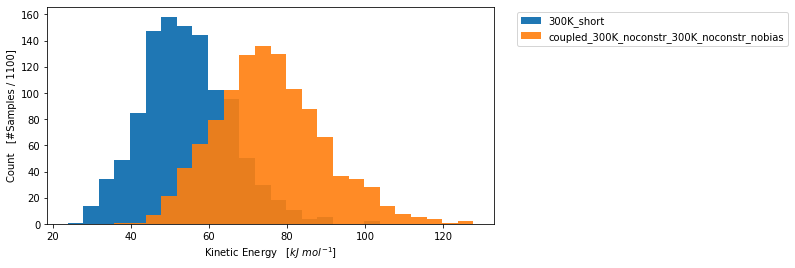

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4))

#plot_energy(ax, '300Ktraj_xmlsystem_samplestraj')
plot_energy(ax, '300K_short',
'coupled_300K_noconstr_300K_noconstr_nobias',
#'coupled_1000K_noconstr_TSFstride10_2_bias','coupled_1000K_noconstr_TSFstride10_2_nobias',
# '300K_noconstr_long_1_samplestraj', '300K_noconstr_long_2_samplestraj', '300K_noconstr_long_3_samplestraj',
# 'TSFtrajstride10_noconstr_long_1_samplestraj', 'TSFtrajstride10_noconstr_long_2_samplestraj', 'TSFtrajstride10_noconstr_long_3_samplestraj',
molecule = 'ala2',kinetic_energy=True)


#plot_energy(ax, '300Ktraj_xmlsystem_samplestraj')
#'TSFtraj_xmlsystem_20000KLL_samplestraj', 'TSFtraj_xmlsystem_20000KLL_savegenerator_samplestraj',

In [26]:
kin_energies = get_energy_fromtxt('trans_pro_1000K_long','Kinetic Energy (kJ/mole)', 'pro')[0]
kin_energies = np.array([kin_energies]).reshape(10000,1)
pot_energies = get_pot_energies('cis_start_long_2_samplestraj', 'pro')[0]

total_energies = np.add(pot_energies, kin_energies)

cis_start_long_2_samplestraj no parameters found
300K
1.0


In [ ]:
def plot_data(ax, *data):
    try:
        binwidth = 4
        bins = np.arange(min(mins.values()), max(maxes.values()) + binwidth ,binwidth)
    except:
        bins=40
    for dataset in data:
        if np.percentile(dataset, 99) > 100:
            ax.hist(dataset,  bins=bins, range=(-50, np.percentile(dataset, 98)), density=False, label=dataset, alpha=(1-data.index(dataset)/10))
            
        else:
            print('no cut')
            ax.hist(dataset,  bins=bins, density=False, label=dataset, alpha=(1-data.index(dataset)/10))
            #ax.hist(energies[fname][0:data_len], bins=40, label=fname, alpha=(1-fnames.index(fname)/10))
            
    
    if total_energy==True or kinetic_energy==True or potential_energy==True:
        ax.set_xlabel(f"{label} Energy   [$kJ$ $mol^{{{-1}}}$]")
    else:
        ax.set_xlabel(f"{label} Energy   [$k_B T$]")
    #ax.set_title(label)
    ax.set_ylabel(f"Count   [#Samples / {data_len}]")
    ax.legend(bbox_to_anchor = (1.04,1), loc='upper left')